# Artificial Intelligence Nanodegree

## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this IPython notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [2]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


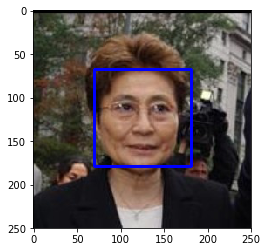

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[1])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)
        
# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path, face_csd = face_cascade):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_csd.detectMultiScale(gray)
    return len(faces) > 0, faces, img

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 

99% detection of faces in human_files, 11% detection of faces in dog_files (1 of the files actually contains a face)

no faces detected
Number of faces detected: 0


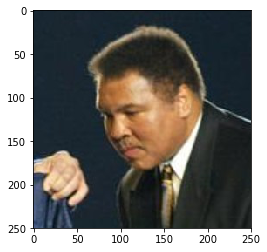

face detected in dogs
Number of faces detected: 1


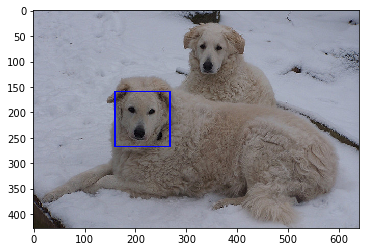

face detected in dogs
Number of faces detected: 1


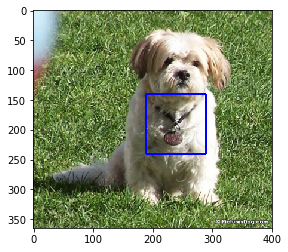

face detected in dogs
Number of faces detected: 1


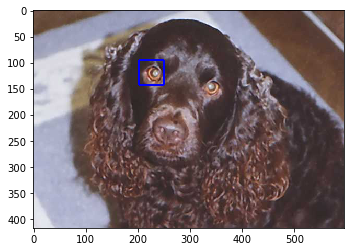

face detected in dogs
Number of faces detected: 1


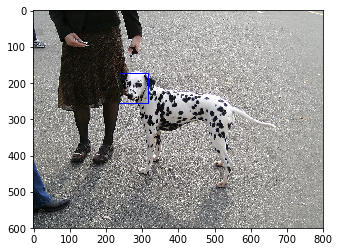

face detected in dogs
Number of faces detected: 1


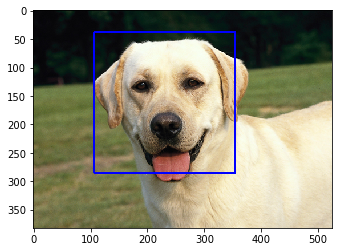

face detected in dogs
Number of faces detected: 1


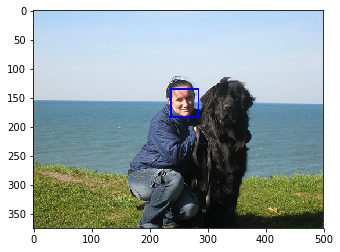

face detected in dogs
Number of faces detected: 1


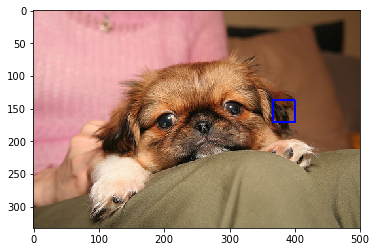

face detected in dogs
Number of faces detected: 1


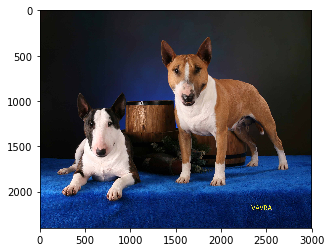

face detected in dogs
Number of faces detected: 1


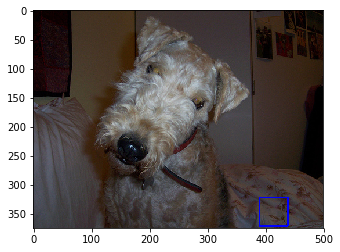

face detected in dogs
Number of faces detected: 1


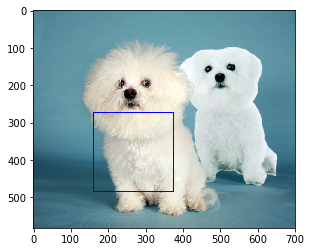

face detected in dogs
Number of faces detected: 1


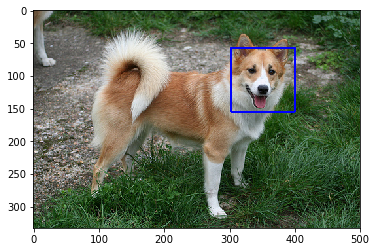

Human faces detection rate  99
False positives in dogs 11


In [5]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

## Test the performance of the face_detector algorithm
## on the images in human_files_short and dog_files_short.
human_accuracy = dog_accuracy = 0
for face in human_files_short:
    test, faces, img = face_detector(face)
    if test:
        human_accuracy +=1
    
    else:
        print ('no faces detected')
        print('Number of faces detected:', len(faces))

        # get bounding box for each detected face
        for (x,y,w,h) in faces:
        # add bounding box to color image
            cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
        # convert BGR image to RGB for plotting
        cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # display the image, along with bounding box
        plt.imshow(cv_rgb)
        plt.show()
        
for dog in dog_files_short:
    test, faces, img = face_detector(dog)
    if test:
        print ('face detected in dogs')
        print('Number of faces detected:', len(faces))

        # get bounding box for each detected face
        for (x,y,w,h) in faces:
        # add bounding box to color image
            cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
        # convert BGR image to RGB for plotting
        cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # display the image, along with bounding box
        plt.imshow(cv_rgb)
        plt.show()
    else:
        dog_accuracy +=1
print ('Human faces detection rate ', human_accuracy)
print ('False positives in dogs', 100- dog_accuracy)


__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer:__

We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on each of the datasets.

4 different opencv facedetctors were tested:
The default testdetector turned out to be the best with 99% accuracy and 11% false positives on dogs. Another notable result was perfomance of haarcascade_frontalface_alt_tree.xml accuracy: 58 false negatives: 1 (Note that the only false negative in dog files contained a human face as well as a dog in the photograph) So essentially the detector is extremely good at eliminating non human faces. It can be used in applications where the picture can be retaken to ensure the human face is not misidentified. See detailed results below

In [23]:
## (Optional) TODO: Report the performance of another  
## face detection algorithm on the LFW dataset
### Feel free to use as many code cells as needed.

#comparing different face detection options provided by opencv
import os
def run_comparison(face_csd=face_cascade):
    """
    This function tests accuracy of a given face detector on a set of real faces
    and also on a set of dog photographs
    face_csd: face_detector model object
    return: accuracy - percentage of faces recognized correctly
            false_negatives percentage of wrongly detected faces in a set of dog photographs
    
    """
    accuracy = false_negatives = 0
    for face in human_files_short:
        test, faces, img = face_detector(face, face_csd)
        if test:
            accuracy +=1
    for dog in dog_files_short:
        test, faces, img = face_detector(dog,face_csd)
        if test:
            false_negatives +=1
    return accuracy, false_negatives

# test all 4 haarcascades detectors
for dirpath,_,filenames in os.walk('haarcascades'):
    for f in filenames:
        face_csd = cv2.CascadeClassifier('haarcascades/'+f)
        accuracy, negatives = run_comparison(face_csd)
        print (f, 'accuracy:', accuracy, 'false negatives:', negatives)
        

haarcascade_frontalface_alt.xml accuracy: 99 false negatives: 11
haarcascade_frontalface_alt2.xml accuracy: 100 false negatives: 20
haarcascade_frontalface_alt_tree.xml accuracy: 58 false negatives: 1
haarcascade_frontalface_default.xml accuracy: 100 false negatives: 58


As results above indicate the alt, alt2 and default deterctors are all good at recognizing faces when they are present, but alt_tree is really good at detecting when the face is not present. In fact the only false negative it produces is when the picture of the dog also has human face in it.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [6]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [3]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path, img_size =224):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(img_size, img_size))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths, fnc = path_to_tensor, imsize = 224):
    list_of_tensors = [fnc(img_path,img_size = imsize) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [4]:
#alternative image loader that attaches black stripes to image instead of distorting it
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
def path_to_tensor_(img_path, img_size = 224):
    #load RGB image as PIL.Image
    img = Image.open(img_path)
    if img.mode != 'RGB':
        img = img.convert('RGB')
    img_height, img_width = img.size
    if img_height > img_width:
        new_height = img_size
        new_width = img_width*new_height//img_height
    else:
        new_width = img_size
        new_height = img_height*new_width//img_width
    img = img.resize((new_height, new_width))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    blank = Image.new('RGB', (img_size,img_size), (0,0,0))
    x1 = image.img_to_array(blank)
    for height in range(len(x)):
        for width in range(len(x[height])):
            for depth in range(3):
                x1[height][width][depth] = x[height][width][depth]
    return np.expand_dims(x1,axis = 0)


### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [5]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [6]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 
Dogs detected in dog_files_short: 100
Dogs detected in human_files_short: 1

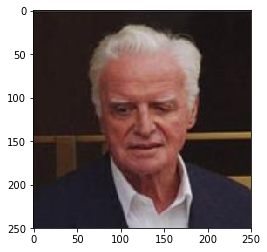

Dogs detected in dog_files_short: 100
Dogs detected in human_files_short: 1


In [14]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
dog_accuracy = human_false_neg = 0
for dog in dog_files_short:
    if dog_detector(dog):
        dog_accuracy +=1
for human in human_files_short:
    # show pictures from human files that are identified as dogs
    if dog_detector(human):
        human_false_neg +=1
        img = cv2.imread(human)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.show()
print ('Dogs detected in dog_files_short:', dog_accuracy)
print ('Dogs detected in human_files_short:', human_false_neg)
    

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [13]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|████████████████████████████████████████████████████████████████████████████████| 836/836 [01:05<00:00, 12.68it/s]


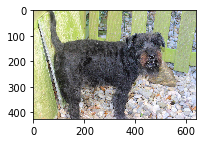

dogImages/train\097.Lakeland_terrier\Lakeland_terrier_06535.jpg


In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(20,2))
img = cv2.imread(train_files[1857])
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()
print (train_files[1857])

In [36]:
# create tensors containing picture data from jpegs for training, validation and testing
train_tens = paths_to_tensor(train_files, fnc = path_to_tensor_, imsize=224).astype('float32')/255
valid_tens = paths_to_tensor(valid_files, fnc = path_to_tensor_, imsize =224).astype('float32')/255
test_tens = paths_to_tensor(test_files, fnc = path_to_tensor_, imsize =224).astype('float32')/255



100%|████████████████████████████████████████████████████████████████████████████████| 836/836 [02:17<00:00,  6.20it/s]


In [37]:
# save results on disk
np.save ('train_s224', train_tens)
np.save ('valid_s224', valid_tens)
np.save ('test_s224', test_tens)


In [7]:
# load tensors from disks (obtain tensors without running all the cells in the notebook)
train_tens = np.load('train_s224.npy')
valid_tens = np.load('valid_s224.npy')
test_tens = np.load('test_s224.npy')

In [18]:
print (train_files[0])
test_tens = paths_to_tensor(test_files, fnc = path_to_tensor_, imsize =224).astype('float32')/255


dogImages/train\095.Kuvasz\Kuvasz_06442.jpg


100%|████████████████████████████████████████████████████████████████████████████████| 836/836 [03:19<00:00,  4.86it/s]


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

We have imported some Python modules to get you started, but feel free to import as many modules as you need.  If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
           
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

__Answer:__ 

I used the cnn architecture suggested above, because it is generally better than a fully connected network at detecting images due to keeping the spatial information from both direction of the picture. The suggested architecture converged really fast, but it was giving very low accuracy so I increased the number of convolutional layers to get accuracy to ~15%

In [5]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()


model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', 
                        input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=256, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=512, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=512, kernel_size=2, padding='same', activation='relu'))
model.add(GlobalAveragePooling2D())


#model.add(Dropout(0.2))
model.add(Dense(133, activation='softmax'))

model.summary()
### TODO: Define your architecture.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 64)      832       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     32896     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 256)       131328    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 28, 28, 256)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 512)       524800    
__________

### Compile the Model

In [9]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [10]:
from keras.preprocessing.image import ImageDataGenerator

# create and configure augmented image generator
datagen_train = ImageDataGenerator(
    width_shift_range=0.15,  # randomly shift images horizontally (10% of total width)
    height_shift_range=0.15,  # randomly shift images vertically (10% of total height)
    zoom_range=[.8,1.25],
    rotation_range =15,
    horizontal_flip=True) # randomly flip images horizontally

# create and configure augmented image generator
datagen_valid = ImageDataGenerator(
    width_shift_range=0.1,  # randomly shift images horizontally (10% of total width)
    height_shift_range=0.1,  # randomly shift images vertically (10% of total height)
    zoom_range=[.8,1.25],
    rotation_range =10,
    horizontal_flip=True) # randomly flip images horizontally

# fit augmented image generator on data
datagen_train.fit(train_tens)
datagen_valid.fit(valid_tens)

In [35]:
print (train_tens.shape)

(6680, 64, 64, 3)


In [22]:
from keras.callbacks import ModelCheckpoint  

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 15
batch_size = 100

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

#model.fit(train_tensors, train_targets, 
#          validation_data=(valid_tensors, valid_targets),
#          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

model.fit_generator(datagen_train.flow(train_tens, train_targets, batch_size=batch_size),
                    steps_per_epoch=train_tens.shape[0] // batch_size,
                    epochs=epochs, verbose=2, callbacks=[checkpointer],
                    validation_data=datagen_valid.flow(valid_tens, valid_targets, batch_size=batch_size),
                    validation_steps=20)

Epoch 1/15
Epoch 00001: val_loss improved from inf to 4.11910, saving model to saved_models/weights.best.from_scratch.hdf5
 - 2192s - loss: 4.0333 - acc: 0.0933 - val_loss: 4.1191 - val_acc: 0.0973
Epoch 2/15
Epoch 00002: val_loss did not improve
 - 2162s - loss: 4.0325 - acc: 0.0968 - val_loss: 4.2743 - val_acc: 0.0556
Epoch 3/15
Epoch 00003: val_loss improved from 4.11910 to 4.08281, saving model to saved_models/weights.best.from_scratch.hdf5
 - 2164s - loss: 3.9465 - acc: 0.1087 - val_loss: 4.0828 - val_acc: 0.0952
Epoch 4/15
Epoch 00004: val_loss improved from 4.08281 to 4.03301, saving model to saved_models/weights.best.from_scratch.hdf5
 - 2157s - loss: 3.9324 - acc: 0.1111 - val_loss: 4.0330 - val_acc: 0.0952
Epoch 5/15
Epoch 00005: val_loss did not improve
 - 2150s - loss: 3.9131 - acc: 0.1117 - val_loss: 4.2059 - val_acc: 0.0743
Epoch 6/15
Epoch 00006: val_loss improved from 4.03301 to 3.93200, saving model to saved_models/weights.best.from_scratch.hdf5
 - 2163s - loss: 3.8657

### Load the Model with the Best Validation Loss

In [25]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

In [27]:
model.load_weights('saved_models/my_model.hdf5')

In [24]:
model.save('saved_models/my_model.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [28]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tens]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 14.9522%


---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [3]:
test_targets.shape

(836, 133)

In [7]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [8]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [9]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [13]:
from keras.callbacks import ModelCheckpoint 
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 3s 405us/step - loss: 12.9012 - acc: 0.1031 - val_loss: 11.7118 - val_acc: 0.1521
Epoch 2/20
6680/6680 [==============================] - 2s 229us/step - loss: 10.8630 - acc: 0.2407 - val_loss: 10.7516 - val_acc: 0.2527
Epoch 3/20
6680/6680 [==============================] - 2s 239us/step - loss: 10.3892 - acc: 0.2991 - val_loss: 10.5402 - val_acc: 0.2683
Epoch 4/20
6680/6680 [==============================] - 2s 229us/step - loss: 10.1535 - acc: 0.3292 - val_loss: 10.4792 - val_acc: 0.2766
Epoch 5/20
6680/6680 [==============================] - 2s 243us/step - loss: 10.0625 - acc: 0.3485 - val_loss: 10.4139 - val_acc: 0.2886
Epoch 6/20
6680/6680 [==============================] - 2s 248us/step - loss: 9.9880 - acc: 0.3584 - val_loss: 10.4281 - val_acc: 0.2982
Epoch 7/20
6680/6680 [==============================] - 2s 250us/step - loss: 9.8398 - acc: 0.3645 - val_loss: 10.3052 - val_a

### Load the Model with the Best Validation Loss

In [14]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [15]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 38.9952%


### Predict Dog Breed with the Model

In [16]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [135]:
### TODO: Obtain bottleneck features from another pre-trained CNN.
import numpy as np
bottleneck_features = np.load('bottleneck_features/DogVGG19Data.npz')
train_vgg19 = bottleneck_features['train']
valid_vgg19 = bottleneck_features['valid']
test_vgg19 = bottleneck_features['test']

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 
I tested all the bottleneck features provided and found that all the network produced similar results. With vgg19 giving around 78% maximum accuracy, both resnet and inception ~81% and xception around 85%. I experimented with several architectures to put on top of the bottleneck features and it turned out that just one layer of densely connected structure before the softmax layer produced the best results. I also played with the number of nodes in the densely connected layer and it seemed that the best results were around 250 nodes. The larger networks both in terms of number of nodes per layer and deepness lead to overfitting without improving the results.

After training the top of the network on the bottleneck features, I tried to retrain it using the data augmentation that was fed throught the xception network for 13 epochs, but the accuracy remained at 85 %



In [136]:
### Testing Vgg19 architecture
VGG19_model = Sequential()
VGG19_model.add(GlobalAveragePooling2D(input_shape=train_vgg19.shape[1:]))
VGG19_model.add(Dense(256, activation='relu'))
VGG19_model.add(Dropout(.3))
VGG19_model.add(Dense(133, activation='softmax'))

VGG19_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_6 ( (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 133)               34181     
Total params: 165,509
Trainable params: 165,509
Non-trainable params: 0
_________________________________________________________________


### (IMPLEMENTATION) Compile the Model

In [137]:
### TODO: Compile the model.
VGG19_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [138]:
### TODO: Train the model.
from keras.callbacks import ModelCheckpoint 
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG19.hdf5', 
                               verbose=1, save_best_only=True)

VGG19_model.fit(train_vgg19, train_targets, 
          validation_data=(valid_vgg19, valid_targets),
          epochs=20, batch_size=100, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 3s 517us/step - loss: 5.3312 - acc: 0.1356 - val_loss: 2.7122 - val_acc: 0.3952
Epoch 2/20
6680/6680 [==============================] - 1s 220us/step - loss: 2.2155 - acc: 0.4496 - val_loss: 1.5062 - val_acc: 0.5868
Epoch 3/20
6680/6680 [==============================] - 1s 218us/step - loss: 1.3800 - acc: 0.6174 - val_loss: 1.2345 - val_acc: 0.6503
Epoch 4/20
6680/6680 [==============================] - 2s 234us/step - loss: 1.0063 - acc: 0.7106 - val_loss: 1.0534 - val_acc: 0.6982
Epoch 5/20
6680/6680 [==============================] - 2s 239us/step - loss: 0.7892 - acc: 0.7573 - val_loss: 1.0527 - val_acc: 0.7066
Epoch 6/20
6680/6680 [==============================] - 2s 232us/step - loss: 0.6379 - acc: 0.8019 - val_loss: 0.9701 - val_acc: 0.7317
Epoch 7/20
6680/6680 [==============================] - 2s 239us/step - loss: 0.5168 - acc: 0.8335 - val_loss: 0.9574 - val_acc: 0.7329
E

6680/6680 [==============================] - 1s 180us/step - loss: 0.1888 - acc: 0.9350 - val_loss: 0.9822 - val_acc: 0.7665
Epoch 17/20
6680/6680 [==============================] - 1s 180us/step - loss: 0.1704 - acc: 0.9430 - val_loss: 1.1147 - val_acc: 0.7557
Epoch 18/20
6680/6680 [==============================] - 1s 180us/step - loss: 0.1719 - acc: 0.9419 - val_loss: 1.1645 - val_acc: 0.7509
Epoch 19/20
6680/6680 [==============================] - 1s 180us/step - loss: 0.1576 - acc: 0.9490 - val_loss: 1.0854 - val_acc: 0.7629
Epoch 20/20
6680/6680 [==============================] - 1s 185us/step - loss: 0.1393 - acc: 0.9522 - val_loss: 1.0352 - val_acc: 0.7749


### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [17]:
### TODO: Load the model weights with the best validation loss.
VGG19_model.load_weights('saved_models/weights.best.VGG19.hdf5')

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [139]:
### TODO: Calculate classification accuracy on the test dataset.
VGG19_predictions = [np.argmax(VGG19_model.predict(np.expand_dims(feature, axis=0))) for feature in test_vgg19]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG19_predictions)==np.argmax(test_targets, axis=1))/len(VGG19_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 78.1100%


In [171]:
#Testing resnet-50
bottleneck_features_r = np.load('bottleneck_features/DogResnet50Data.npz')
train_r = bottleneck_features_r['train']
valid_r = bottleneck_features_r['valid']
test_r = bottleneck_features_r['test']

In [172]:
#defining resnet-50 architecture
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
r_model = Sequential()
r_model.add(GlobalAveragePooling2D(input_shape=train_r.shape[1:]))
r_model.add(Dense(200, activation='relu'))
r_model.add(Dropout(.1))
r_model.add(Dense(133, activation='softmax'))

In [173]:
r_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [174]:
from keras.callbacks import ModelCheckpoint 
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.resnet.hdf5', 
                               verbose=1, save_best_only=True)

r_model.fit(train_r, train_targets, 
          validation_data=(valid_r, valid_targets),
          epochs=15, batch_size=100, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/15
6680/6680 [==============================] - 3s 522us/step - loss: 2.5861 - acc: 0.4133 - val_loss: 1.2834 - val_acc: 0.6563
Epoch 2/15
6680/6680 [==============================] - 2s 225us/step - loss: 0.9120 - acc: 0.7406 - val_loss: 0.9185 - val_acc: 0.7186
Epoch 3/15
6680/6680 [==============================] - 1s 208us/step - loss: 0.5492 - acc: 0.8310 - val_loss: 0.7476 - val_acc: 0.7593
Epoch 4/15
6680/6680 [==============================] - 1s 220us/step - loss: 0.3951 - acc: 0.8801 - val_loss: 0.6978 - val_acc: 0.7665
Epoch 5/15
6680/6680 [==============================] - 1s 206us/step - loss: 0.2763 - acc: 0.9151 - val_loss: 0.6684 - val_acc: 0.8048
Epoch 6/15
6680/6680 [==============================] - 1s 215us/step - loss: 0.2142 - acc: 0.9335 - val_loss: 0.6258 - val_acc: 0.8120
Epoch 7/15
6680/6680 [==============================] - 1s 194us/step - loss: 0.1664 - acc: 0.9487 - val_loss: 0.6417 - val_acc: 0.8275
E

Epoch 9/15
6680/6680 [==============================] - 1s 206us/step - loss: 0.0961 - acc: 0.9729 - val_loss: 0.6020 - val_acc: 0.8204
Epoch 10/15
6680/6680 [==============================] - 1s 189us/step - loss: 0.0847 - acc: 0.9766 - val_loss: 0.6587 - val_acc: 0.8192
Epoch 11/15
6680/6680 [==============================] - 1s 192us/step - loss: 0.0704 - acc: 0.9802 - val_loss: 0.6458 - val_acc: 0.8228
Epoch 12/15
6680/6680 [==============================] - 1s 199us/step - loss: 0.0597 - acc: 0.9831 - val_loss: 0.7100 - val_acc: 0.8084
Epoch 13/15
6680/6680 [==============================] - 1s 194us/step - loss: 0.0478 - acc: 0.9856 - val_loss: 0.6692 - val_acc: 0.8216
Epoch 14/15
6680/6680 [==============================] - 1s 197us/step - loss: 0.0494 - acc: 0.9844 - val_loss: 0.6520 - val_acc: 0.8347
Epoch 15/15
6680/6680 [==============================] - 1s 197us/step - loss: 0.0399 - acc: 0.9898 - val_loss: 0.6226 - val_acc: 0.8371


In [175]:
r_predictions = [np.argmax(r_model.predict(np.expand_dims(feature, axis=0))) for feature in test_r]

# report test accuracy
test_accuracy = 100*np.sum(np.array(r_predictions)==np.argmax(test_targets, axis=1))/len(r_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 81.1005%


In [176]:
#Testing inception architecture
bottleneck_features_in = np.load('bottleneck_features/DogInceptionV3Data.npz')
train_inception = bottleneck_features_in['train']
valid_inception = bottleneck_features_in['valid']
test_inception = bottleneck_features_in['test']

In [177]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
inception_model = Sequential()
inception_model.add(GlobalAveragePooling2D(input_shape=train_inception.shape[1:]))
inception_model.add(Dense(256, activation='relu'))
inception_model.add(Dropout(.3))
inception_model.add(Dense(133, activation='softmax'))


inception_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_16  (None, 2048)              0         
_________________________________________________________________
dense_29 (Dense)             (None, 256)               524544    
_________________________________________________________________
dropout_15 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 133)               34181     
Total params: 558,725
Trainable params: 558,725
Non-trainable params: 0
_________________________________________________________________


In [178]:
inception_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [179]:
## from keras.callbacks import ModelCheckpoint 
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.inc.hdf5', 
                               verbose=1, save_best_only=True)

inception_model.fit(train_inception, train_targets, 
          validation_data=(valid_inception, valid_targets),
          epochs=20, batch_size=100, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 5s 751us/step - loss: 1.9692 - acc: 0.5558 - val_loss: 0.7068 - val_acc: 0.7976
Epoch 2/20
6680/6680 [==============================] - 3s 428us/step - loss: 0.7939 - acc: 0.7713 - val_loss: 0.5716 - val_acc: 0.8263
Epoch 3/20
6680/6680 [==============================] - 3s 393us/step - loss: 0.5923 - acc: 0.8142 - val_loss: 0.5774 - val_acc: 0.8168
Epoch 4/20
6680/6680 [==============================] - 3s 430us/step - loss: 0.4727 - acc: 0.8515 - val_loss: 0.5623 - val_acc: 0.8204
Epoch 5/20
6680/6680 [==============================] - 3s 393us/step - loss: 0.4144 - acc: 0.8644 - val_loss: 0.6159 - val_acc: 0.8263
Epoch 6/20
6680/6680 [==============================] - 3s 402us/step - loss: 0.3508 - acc: 0.8828 - val_loss: 0.5138 - val_acc: 0.8599
Epoch 7/20
6680/6680 [==============================] - 2s 367us/step - loss: 0.2898 - acc: 0.9016 - val_loss: 0.5214 - val_acc: 0.8491
E

6680/6680 [==============================] - 2s 365us/step - loss: 0.1858 - acc: 0.9341 - val_loss: 0.6543 - val_acc: 0.8371
Epoch 12/20
6680/6680 [==============================] - 3s 388us/step - loss: 0.1551 - acc: 0.9469 - val_loss: 0.6049 - val_acc: 0.8431
Epoch 13/20
6680/6680 [==============================] - 2s 363us/step - loss: 0.1522 - acc: 0.9469 - val_loss: 0.6241 - val_acc: 0.8455
Epoch 14/20
6680/6680 [==============================] - 2s 353us/step - loss: 0.1372 - acc: 0.9545 - val_loss: 0.6341 - val_acc: 0.8503
Epoch 15/20
6680/6680 [==============================] - 2s 353us/step - loss: 0.1174 - acc: 0.9591 - val_loss: 0.7123 - val_acc: 0.8287
Epoch 16/20
6680/6680 [==============================] - 2s 356us/step - loss: 0.1169 - acc: 0.9591 - val_loss: 0.6731 - val_acc: 0.8491
Epoch 17/20
6680/6680 [==============================] - 2s 360us/step - loss: 0.1121 - acc: 0.9605 - val_loss: 0.6689 - val_acc: 0.8515
Epoch 18/20
6680/6680 [==============================

In [183]:
inception_model.load_weights('saved_models/weights.best.inc.hdf5')

In [184]:
inception_predictions = [np.argmax(inception_model.predict(np.expand_dims(feature, axis=0))) for feature in test_inception]

# report test accuracy
test_accuracy = 100*np.sum(np.array(inception_predictions)==np.argmax(test_targets, axis=1))/len(inception_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 80.2632%


In [6]:
bottleneck_features_x = np.load('bottleneck_features/DogXceptionData.npz')
train_xception = bottleneck_features_x['train']
valid_xception = bottleneck_features_x['valid']
test_xception = bottleneck_features_x['test']

In [7]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
xception_model = Sequential()
xception_model.add(GlobalAveragePooling2D(input_shape=train_xception.shape[1:]))
xception_model.add(Dense(256, activation='relu'))
xception_model.add(Dropout(.3))

xception_model.add(Dense(133, activation='softmax'))

xception_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               524544    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 133)               34181     
Total params: 558,725
Trainable params: 558,725
Non-trainable params: 0
_________________________________________________________________


In [85]:
xception_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [81]:
from keras.callbacks import ModelCheckpoint 
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.xcept5.hdf5', 
                               verbose=1, save_best_only=True)

xception_model.fit(train_xception, train_targets, 
          validation_data=(valid_xception, valid_targets),
          epochs=20, batch_size=100, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 8s 1ms/step - loss: 1.4843 - acc: 0.6443 - val_loss: 0.6303 - val_acc: 0.8216
Epoch 2/20
6680/6680 [==============================] - 5s 758us/step - loss: 0.5831 - acc: 0.8154 - val_loss: 0.5996 - val_acc: 0.8120
Epoch 3/20
6680/6680 [==============================] - 5s 791us/step - loss: 0.4299 - acc: 0.8599 - val_loss: 0.5181 - val_acc: 0.8347
Epoch 4/20
6680/6680 [==============================] - 5s 744us/step - loss: 0.3391 - acc: 0.8928 - val_loss: 0.5243 - val_acc: 0.8419
Epoch 5/20
6680/6680 [==============================] - 5s 784us/step - loss: 0.2656 - acc: 0.9081 - val_loss: 0.5759 - val_acc: 0.8287
Epoch 6/20
6680/6680 [==============================] - 5s 776us/step - loss: 0.2276 - acc: 0.9254 - val_loss: 0.5598 - val_acc: 0.8240
Epoch 7/20
6680/6680 [==============================] - 5s 740us/step - loss: 0.1953 - acc: 0.9334 - val_loss: 0.5358 - val_acc: 0.8431
Epo

In [58]:
xception_model.save('saved_models/xceptionbest3.hdf5')

In [86]:
#xception_model.load_weights('saved_models/weights.best.xcept.hdf5')
xception_model.load_weights('saved_models/xceptionbest2.hdf5')


In [61]:
xception_model.load_weights('saved_models/weights.best.xcept4.hdf5')

In [87]:
xception_predictions = [np.argmax(xception_model.predict(np.expand_dims(feature, axis=0))) for feature in test_xception]

# report test accuracy
test_accuracy = 100*np.sum(np.array(xception_predictions)==np.argmax(test_targets, axis=1))/len(xception_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 85.4067%


In [70]:
xception_model.layers[1].get_weights()

[array([[-0.01204887,  0.00747126,  0.07827996, ..., -0.02453444,
          0.00201884,  0.01387767],
        [-0.03497253,  0.07058224, -0.05923694, ...,  0.02921138,
          0.01066457,  0.02024089],
        [-0.05498956,  0.03798883,  0.01964665, ...,  0.03217941,
          0.03273056, -0.04903594],
        ..., 
        [-0.06746844,  0.02398886, -0.0695522 , ..., -0.00679094,
         -0.04456907, -0.05027505],
        [-0.02767159, -0.01871063,  0.11992648, ...,  0.08023302,
          0.10101077, -0.02687955],
        [ 0.00147956, -0.00476572, -0.03259933, ...,  0.01617531,
         -0.01039745, -0.01601383]], dtype=float32),
 array([ -4.85247709e-02,  -3.62070883e-03,  -3.03578246e-02,
         -2.63643079e-02,  -1.73980389e-02,  -4.20669280e-02,
         -4.34817839e-03,  -2.60047391e-02,  -5.34834005e-02,
         -3.65623757e-02,  -5.52391866e-04,  -6.42011985e-02,
         -3.53111811e-02,  -5.30183800e-02,  -1.53845325e-02,
         -3.97301279e-02,  -2.54280400e-03,  -2

In [5]:
from keras.applications.xception import Xception, preprocess_input
from keras.layers import Input



#Xception model
xmodel = Xception(include_top = False, weights='imagenet')

In [7]:
bottleneck_features_x = np.load('bottleneck_features/DogXceptionData.npz')
train_xception = bottleneck_features_x['train']
valid_xception = bottleneck_features_x['valid']
test_xception = bottleneck_features_x['test']

In [29]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

xception_model=Sequential()
xception_model.add(GlobalAveragePooling2D(input_shape=train_xception.shape[1:]))
xception_model.add(Dense(256, activation='relu'))
xception_model.add(Dropout(.3))

xception_model.add(Dense(133, activation='softmax'))

xception_model.summary()

xception_model.load_weights('saved_models/xceptionbest2.hdf5')
xception_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               524544    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 133)               34181     
Total params: 558,725
Trainable params: 558,725
Non-trainable params: 0
_________________________________________________________________


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [9]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path, img_size =224):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(img_size, img_size))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor

    return np.expand_dims(x, axis=0)

In [10]:
### A function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.
def predict_breed (img_path):
    input_tensor = path_to_tensor(img_path, img_size = 224)
    #print (input_tensor.shape)
    input_tensor = preprocess_input(input_tensor)
    xmodel_prediction = xmodel.predict(input_tensor)
    #print (xmodel_prediction.shape)
    return np.argmax(xception_model.predict(xmodel_prediction))

In [11]:
from keras.preprocessing.image import ImageDataGenerator
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


train_tens = paths_to_tensor(train_files, fnc = path_to_tensor, imsize=224).astype('float32')/127.5 -1
valid_tens = paths_to_tensor(valid_files, fnc = path_to_tensor, imsize =224).astype('float32')/127.5 -1
# create and configure augmented image generator


datagen_train = ImageDataGenerator(
    width_shift_range=0.15,  # randomly shift images horizontally (10% of total width)
    height_shift_range=0.15,  # randomly shift images vertically (10% of total height)
    zoom_range=[.8,1.25],
    rotation_range =15,
    horizontal_flip=True) # randomly flip images horizontally

# create and configure augmented image generator
datagen_valid = ImageDataGenerator(
    width_shift_range=0.1,  # randomly shift images horizontally (10% of total width)
    height_shift_range=0.1,  # randomly shift images vertically (10% of total height)
    zoom_range=[.8,1.25],
    rotation_range =10,
    horizontal_flip=True) # randomly flip images horizontally

# fit augmented image generator on data
datagen_train.fit(train_tens)
datagen_valid.fit(valid_tens)




100%|████████████████████████████████████████████████████████████████████████████████| 835/835 [01:07<00:00, 12.35it/s]


In [25]:
datagen_train.fit(train_tens)
datagen_valid.fit(valid_tens)

In [33]:
# generator for tuning the network with augmentation data based on Xception network
def generator(datagen, x, y, batch_size =32):
    """
    Parameters:
    datagen - original datagenerator
    x - input data
    y - data labels
    batch_size - size of 1 batch
    
    return:
    out_batch: input data x transformed by xception network
    y_batch - same as original data labels
    """
    for X_batch, Y_batch in datagen.flow(x, y, batch_size):
        #transform the input that represents a picture to xception bottleneck featurs
        
        out_batch = xmodel.predict(X_batch)
        yield out_batch, Y_batch
        



In [41]:
from keras.callbacks import ModelCheckpoint  
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.xceptImproved1.hdf5', 
                               verbose=1, save_best_only=True)

# second run after running for 5 epochs for a total of 13 epochs retraining.
#The original model was trained on bottleneck_features and now retrained with data augmentation

batch_size = 100
steps = len(train_targets)//batch_size
val_steps = len(valid_targets)//batch_size
xception_model.fit_generator(generator(datagen_train, train_tens, train_targets, batch_size), steps_per_epoch = steps,
                             callbacks=[checkpointer], epochs = 8, verbose =1,
                             validation_data=generator(datagen_valid, valid_tens, valid_targets, batch_size),
                             validation_steps=val_steps)

Epoch 1/8
66/66 [==============================] - 4835s 73s/step - loss: 0.3330 - acc: 0.8967 - val_loss: 0.7782 - val_acc: 0.8137
Epoch 2/8
66/66 [==============================] - 4308s 65s/step - loss: 0.3120 - acc: 0.9016 - val_loss: 0.6684 - val_acc: 0.8262
Epoch 3/8
66/66 [==============================] - 4294s 65s/step - loss: 0.3033 - acc: 0.9064 - val_loss: 0.6758 - val_acc: 0.8212
Epoch 4/8
66/66 [==============================] - 4302s 65s/step - loss: 0.2964 - acc: 0.9064 - val_loss: 0.6269 - val_acc: 0.8338
Epoch 5/8


66/66 [==============================] - 4300s 65s/step - loss: 0.2888 - acc: 0.9086 - val_loss: 0.6641 - val_acc: 0.8162
Epoch 6/8
66/66 [==============================] - 4276s 65s/step - loss: 0.2822 - acc: 0.9094 - val_loss: 0.6077 - val_acc: 0.8437
Epoch 7/8
66/66 [==============================] - 4298s 65s/step - loss: 0.2798 - acc: 0.9099 - val_loss: 0.6866 - val_acc: 0.8338
Epoch 8/8
66/66 [==============================] - 4339s 66s/step - loss: 0.2569 - acc: 0.9189 - val_loss: 0.7103 - val_acc: 0.8237


In [43]:
xception_model.save('saved_models/xceptionbestImp1.hdf5')

In [44]:
xception_model.load_weights('saved_models/weights.best.xceptImproved1.hdf5')

In [39]:
xception_model.load_weights('saved_models/xceptionbestImp1.hdf5')

In [81]:
#same results as before after 13 epochs
xception_predictions = [np.argmax(xception_model.predict(np.expand_dims(feature, axis=0))) for feature in test_xception]

# report test accuracy
test_accuracy = 100*np.sum(np.array(xception_predictions)==np.argmax(test_targets, axis=1))/len(xception_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 85.0478%


---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [95]:
from keras.applications.resnet50 import preprocess_input, decode_predictions
import cv2 
from keras.applications.resnet50 import ResNet50
import matplotlib.pyplot as plt                        
%matplotlib inline 

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

def face_detector(img_path, face_csd):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_csd.detectMultiScale(gray)
    return len(faces) > 0, faces, img

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151))


def show_picture(img_path):
    img = cv2.imread(img_path)
    # convert BGR image to RGB for plotting
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # display the image, along with bounding box
    plt.imshow(cv_rgb)
    plt.show()


In [125]:
from keras.applications.xception import  preprocess_input as pi
# a function that predicts the dog breed of a given picuture (it does not have to be a dog)
def predict_breed (img_path):
    input_tensor = path_to_tensor(img_path, img_size = 224)
    input_tensor = pi(input_tensor)
    xmodel_prediction = xmodel.predict(input_tensor)
    prediction = xception_model.predict(xmodel_prediction)
    argmax = np.argmax(prediction)
    return argmax, prediction[0][argmax]*100

In [126]:
# this function takes a path to a picture and determines if the picture contains a dog or a human
# if picture contains a dog the return is a dog breed, if picture contains human face it
# returns the dog breed that human resembles the most
# if the picture does not contain either dog or human error is shown
def who_is_it(img_path):
    message1 =""
    message2 =''
    message3 =""
    if dog_detector (img_path):
        message1 = "This is a dog"
        message2 = 'It looks like...'
    else:
        # this face detector is 99% accurate at identifying the face when it is present
        # and gives only 11% false positive. It seems the best out of the 4 detectors tested
        face_casc1 = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')
        if face_detector(img_path, face_casc1):
            message1 = "Hello Human!"
            message2 = "You look like..."
        else: #neither dog nor human detected
            message1 = "Please provide picture of either dog or human"
    print (message1)
    show_picture (img_path)
    if message2 == '':
        return
    print (message2)
    (breed, resemblance) = predict_breed(img_path)
    print (dog_names[breed], ', resemblance:', resemblance, "%")
    
            
        
    

---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ The results were a little bit different than I expected. One thing in particular that impressed me was that I have a dog of a mixed breed. I always thought that the dog is closest to Labrador retriver, however the algorithm was actually able to find a breed beauceron that I've never heard of before, but that resembles my dog much more than the labrador from which it is a partial mix :).

Another thing that I noticed is that sometimes even when I had very similar appearing photographs of humans they produced very different results in terms of the dog breed that they resembled.

Improvements:

1) One thing that needs improvement is that humans should not be identified as dogs, as happened to one of my photographs. It is especially tricky, because it was a photograph of my ex gf. Yet I don't think she looks that bad :) Jokes aside, though I understand that it might be really embarassing for some people. Additional check might be inserted inside the if dog_detector branch to make sure that the photograph is not of human being...

2) provide a way for a user to specify the path to photographs through ui

3) save results to a file in a form of a postcard

*******************************


Hello Human!


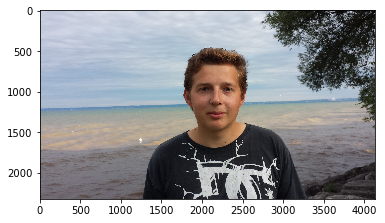

You look like...
Plott , resemblance: 18.7175378203 %


********************************


*******************************


Hello Human!


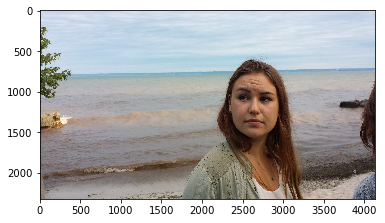

You look like...
Havanese , resemblance: 51.6481399536 %


********************************


*******************************


This is a dog


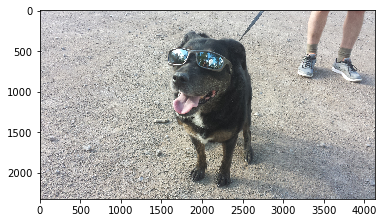

It looks like...
French_bulldog , resemblance: 19.1027581692 %


********************************


*******************************


This is a dog


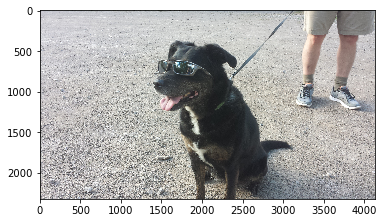

It looks like...
Beauceron , resemblance: 96.5586602688 %


********************************


*******************************


Hello Human!


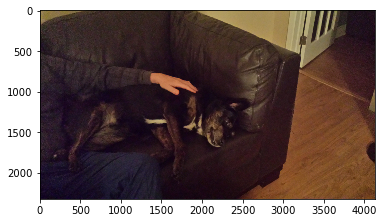

You look like...
Dachshund , resemblance: 40.9411817789 %


********************************


*******************************


Hello Human!


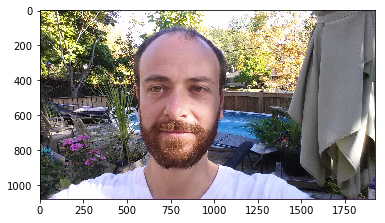

You look like...
Italian_greyhound , resemblance: 47.3672956228 %


********************************


*******************************


Hello Human!


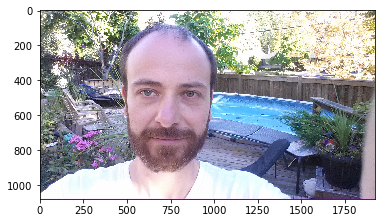

You look like...
Lowchen , resemblance: 25.716483593 %


********************************


*******************************


Hello Human!


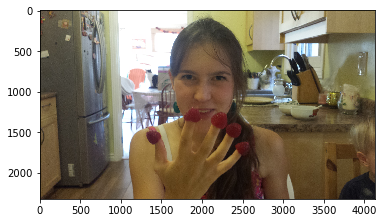

You look like...
Norwich_terrier , resemblance: 73.3288764954 %


********************************


*******************************


Hello Human!


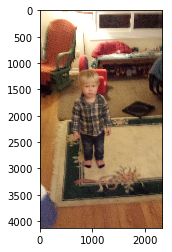

You look like...
Doberman_pinscher , resemblance: 79.819393158 %


********************************


*******************************


Hello Human!


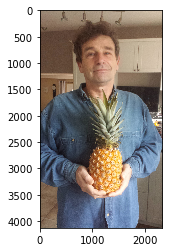

You look like...
Anatolian_shepherd_dog , resemblance: 34.9877327681 %


********************************


*******************************


Hello Human!


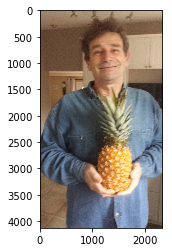

You look like...
German_shorthaired_pointer , resemblance: 24.9729603529 %


********************************


*******************************


Hello Human!


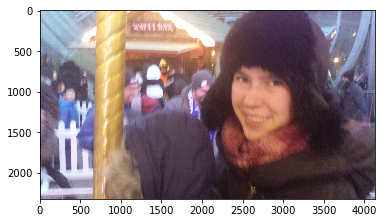

You look like...
Pomeranian , resemblance: 25.9468823671 %


********************************


*******************************


Hello Human!


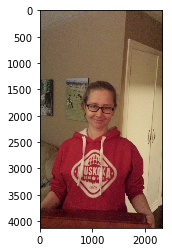

You look like...
Doberman_pinscher , resemblance: 32.3400527239 %


********************************


*******************************


Hello Human!


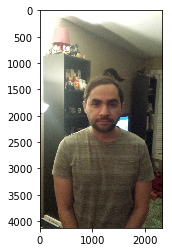

You look like...
Basenji , resemblance: 42.6749408245 %


********************************


*******************************


Hello Human!


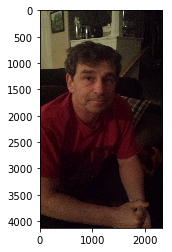

You look like...
Bloodhound , resemblance: 27.5755107403 %


********************************


*******************************


Hello Human!


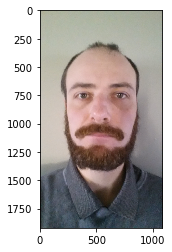

You look like...
Dachshund , resemblance: 43.6476975679 %


********************************


*******************************


Hello Human!


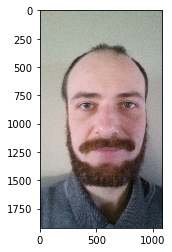

You look like...
Silky_terrier , resemblance: 30.6240588427 %


********************************


*******************************


Hello Human!


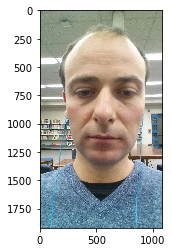

You look like...
Dachshund , resemblance: 98.0110824108 %


********************************


*******************************


Hello Human!


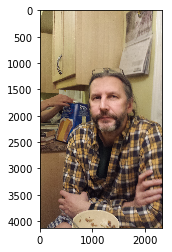

You look like...
Doberman_pinscher , resemblance: 59.1922104359 %


********************************


*******************************


Hello Human!


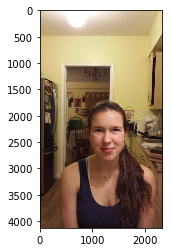

You look like...
German_pinscher , resemblance: 21.0390791297 %


********************************


*******************************


Hello Human!


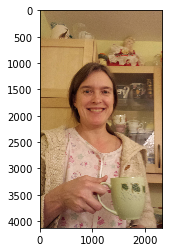

You look like...
Chesapeake_bay_retriever , resemblance: 75.0660419464 %


********************************


*******************************


Hello Human!


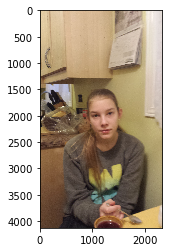

You look like...
Doberman_pinscher , resemblance: 94.4315552711 %


********************************


*******************************


Hello Human!


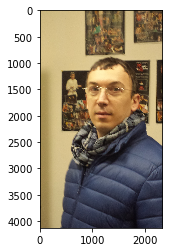

You look like...
Doberman_pinscher , resemblance: 13.8604134321 %


********************************


*******************************


Hello Human!


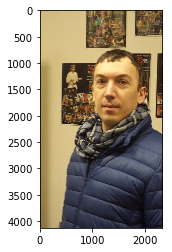

You look like...
Doberman_pinscher , resemblance: 45.6867009401 %


********************************


*******************************


This is a dog


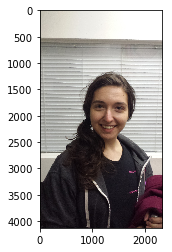

It looks like...
Dachshund , resemblance: 14.4782572985 %


********************************


*******************************


This is a dog


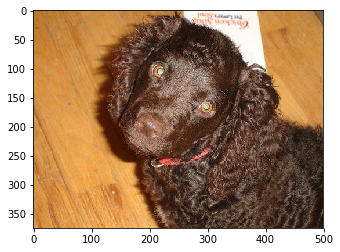

It looks like...
Curly-coated_retriever , resemblance: 99.6446549892 %


********************************


*******************************


This is a dog


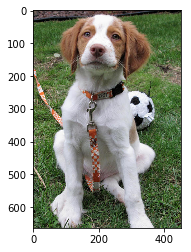

It looks like...
Brittany , resemblance: 99.5977461338 %


********************************


*******************************


This is a dog


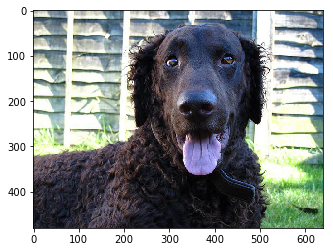

It looks like...
Curly-coated_retriever , resemblance: 99.9991178513 %


********************************


*******************************


This is a dog


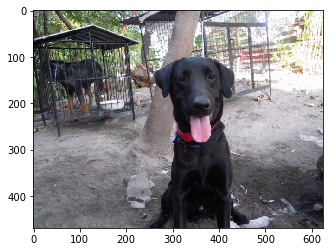

It looks like...
Labrador_retriever , resemblance: 99.3463635445 %


********************************


*******************************


This is a dog


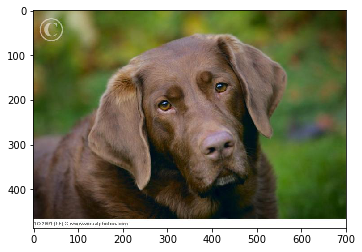

It looks like...
Labrador_retriever , resemblance: 66.5779650211 %


********************************


*******************************


This is a dog


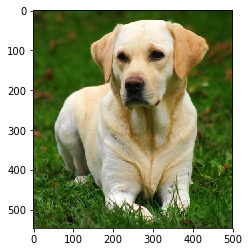

It looks like...
Labrador_retriever , resemblance: 99.9955415726 %


********************************


*******************************


This is a dog


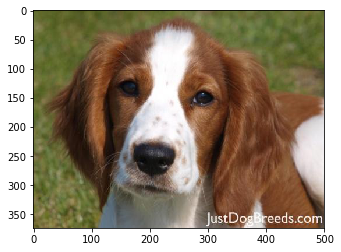

It looks like...
Welsh_springer_spaniel , resemblance: 96.1557209492 %


********************************




In [128]:
#Test results
test_paths = np.array(glob("FinalTest/*"))
for path in test_paths:
    print ('*******************************\n\n')
    who_is_it (path)
    print ('\n\n********************************\n\n')